# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [2]:
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plot
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
#import cv2
import hashlib
import os
from urllib.request import urlretrieve
from PIL import Image
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math


In [3]:
# Load pickled data

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    #print(train)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    #print (test)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
images = X_train[0]
images_shape = np.shape(images)

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", images_shape)
print("Number of classes =", n_classes)



Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [6]:
#ax = sns.countplot(x="labels", data=train)

In [7]:
def show_images(images):
        
    #Split the figure in 3 rows and 3 columns to put images
    figure, axes = plot.subplots(10,10)
    
    # hspace vertical space reserve for white space between subplots
    # wspace horizontal space reserve for white space between subplots
    figure.subplots_adjust(hspace=0.2, wspace=0.2)
    
    for i, ax in enumerate(axes.flat):
        image_shape = np.shape(images[i])
        ax.imshow(images[i].reshape(image_shape), cmap='binary')
        #xlabel = i 

        #Show the number of image as the label on the x-axis.
        #ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plot.show()

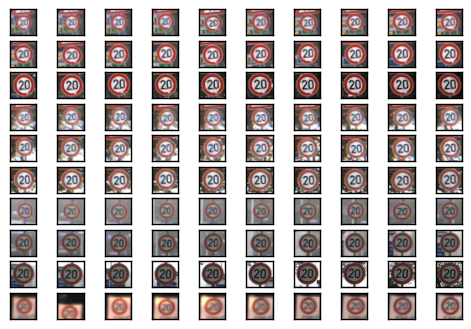

In [8]:
sample_train_images = X_train[0:100] 
show_images(sample_train_images)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [10]:
#def grayscale(array):
#    """Applies the Grayscale transform
#    This will return an image with only one color channel
#    but NOTE: to see the returned image as grayscale
#    you should call plt.imshow(gray, cmap='gray')"""
#    greyscale_data = []
#
#    for i in range(0,array.shape[0]):
#        image = array[i]
#        grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#        greyscale_data.append(grey_image)
#        
#    return np.array(greyscale_data)


def grayscale(array):
    greyscale_data = []

    for i in range(0,array.shape[0]):
        image = array[i]        
        grey_image = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]
        greyscale_data.append(grey_image)
        
        
    return np.array(greyscale_data)

X_train = grayscale(X_train)
X_test = grayscale(X_test)

print (X_train.shape)
print (X_test.shape)


(39209, 32, 32)
(12630, 32, 32)


In [11]:
def flatten_gray(array):
    flat_data = []
    
    for i in range(0,array.shape[0]):
        image = array[i]
        #Return a copy of the array collapsed into one dimension.
        data = np.array (image, dtype = np.float32).flatten()
        flat_data.append(data)
        
    return np.array(flat_data)

X_train = flatten_gray(X_train)
X_test = flatten_gray(X_test)

print (X_train.shape)
print (X_test.shape)

(39209, 1024)
(12630, 1024)


In [12]:
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    #costants
    a = 0.1
    b = 0.9
    xmin = 0
    xmax = 255
    
    x = image_data
    
    x_prime = a + ((x-xmin)*(b-a))/(xmax-xmin)
    
    return x_prime

X_train = normalize_greyscale(X_train)
X_test = normalize_greyscale(X_test)

print (X_train.shape)
print (X_test.shape)

(39209, 1024)
(12630, 1024)


In [13]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
#clases = encoder.classes_
#print (clases)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32

y_train = y_train.astype(np.float32)

y_test = y_test.astype(np.float32)



In [15]:
# Get randomized datasets for training and validation

#test_size : represent the proportion of the dataset to include in the test split. 
#If int, represents the absolute number of test samples

X_train, X_valid, y_train, y_valid = train_test_split(
    
    X_train,
    
    y_train,
    
    test_size=0.15,
    
    random_state=832289)

print (X_train.shape)
#print('Training features and labels randomized and split.')

(28327, 1024)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [16]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [17]:
#creating nodes for the input images and target output classes.
x = tf.placeholder(tf.float32, shape=[None, 1024])
y_ = tf.placeholder(tf.float32, shape=[None, 43])

In [18]:
#define the weights W and biases b for model
W = tf.Variable(tf.zeros([1024,43]))
b = tf.Variable(tf.zeros([43]))

In [19]:
#Helper functions to create weights and biases

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    
    return tf.Variable(initial)

In [20]:
#Function for Convolution
def conv2d(x, W):
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [22]:
#Function for MAX-pooling
def max_pool_2x2(x):
    
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [23]:
#First Convolutional Layer
#The convolutional will compute 32 features for each 5x5 patch
W_conv1 = weight_variable([5, 5, 1, 32])

#The bias vector has a component for each output channel.
b_conv1 = bias_variable([32])


In [24]:
#Image shape 32x32, and 1 channel because the image is in Grayscale
#Resahep x to a 4d tensor
x_image = tf.reshape(x, [-1,32,32,1])

In [25]:
#Apply a one liner to convolve the x_image with weight tensor and add the bias. Apply the ReLu function.
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

#finally Max pooling
h_pool1 = max_pool_2x2(h_conv1)

In [26]:
#Second Convolutional Layer
#64 features for each 5x5 patch.
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [27]:
#Fully Connected Layer with 1024 neurons
W_fc1 = weight_variable([8 * 8 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [28]:
#Dropout, in order to reduce overfitting.

#placeholder of the probability that the neuron is kept during dropout
keep_prob = tf.placeholder(tf.float32)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [29]:
#Readout layer

W_fc2 = weight_variable([1024, 43])
b_fc2 = bias_variable([43])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


In [30]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(8.8e-4).minimize(cross_entropy)
#above with 40bach
#train_step = tf.train.AdamOptimizer(9e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

# Train and Evaluate the model

In [37]:
import datetime


batch_size = 13
total_samples = X_train.shape[0]
epochs = 5

print (total_samples)

#Loops (at batch size) to get through data once.
loops = int(total_samples / batch_size) 
print (loops)


28327
2179


In [38]:
print("Start ",datetime.datetime.now().time())

for i in range(epochs):
    for j in range(loops):
        
        batch_start = j*batch_size
        batch_features = X_train[batch_start:(batch_start + batch_size)]
        batch_labels = y_train[batch_start:(batch_start + batch_size)] 

        if j%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_features, y_: batch_labels, keep_prob: 1.0})
            print("step %d, training accuracy %g, batch start %d"%(j, train_accuracy, batch_start))

    #  print(batch_features)
    #  print(type(batch_features))
    #  print(batch_features.shape)

    #  print(batch_labels)   
    #  print(type(batch_labels))
    #  print(batch_labels.shape)    
    
    
        train_step.run(feed_dict={x: batch_features, y_: batch_labels, keep_prob: 0.5})
        
        
    print("valid accuracy %g"%accuracy.eval(feed_dict={x: X_valid, y_: y_valid, keep_prob: 1.0}))   
 
    
print("test accuracy %g"%accuracy.eval(feed_dict={x: X_test, y_: y_test, keep_prob: 1.0}))    

print ("Finished ", datetime.datetime.now().time())

Start  15:59:13.671361
step 0, training accuracy 1, batch start 0
step 100, training accuracy 0.923077, batch start 1300
step 200, training accuracy 0.923077, batch start 2600
step 300, training accuracy 0.923077, batch start 3900
step 400, training accuracy 0.846154, batch start 5200
step 500, training accuracy 0.769231, batch start 6500
step 600, training accuracy 1, batch start 7800
step 700, training accuracy 1, batch start 9100
step 800, training accuracy 0.846154, batch start 10400
step 900, training accuracy 0.923077, batch start 11700
step 1000, training accuracy 0.769231, batch start 13000
step 1100, training accuracy 0.846154, batch start 14300
step 1200, training accuracy 0.923077, batch start 15600
step 1300, training accuracy 1, batch start 16900
step 1400, training accuracy 0.846154, batch start 18200
step 1500, training accuracy 0.923077, batch start 19500
step 1600, training accuracy 1, batch start 20800
step 1700, training accuracy 1, batch start 22100
step 1800, train

ResourceExhaustedError: OOM when allocating tensor with shape[5000,32,32,32]
	 [[Node: add = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Conv2D, Variable_3/read)]]

Caused by op 'add', defined at:
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-832ae1cce9c2>", line 2, in <module>
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 751, in binary_op_wrapper
    return func(x, y, name=name)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 71, in add
    result = _op_def_lib.apply_op("Add", x=x, y=y, name=name)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[5000,32,32,32]
	 [[Node: add = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Conv2D, Variable_3/read)]]


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.